# Code for CUQIpy paper 2, section 4. CUQIpy-FEniCS example: Electrical Impedance Tomography (EIT)

**Note: The exact paper figures are shown at the very end of this notebook.**

This notebook demonstrates setting up an Electrical Impedance Tomography (EIT) problem in `CUQIpy`. It uses the plug-in `CUQIpy-FEniCS` to solve the forward problem and interface with `CUQIpy` Bayesian modeling and sampling tools. We are after inferring the conductivity field in a 2D domain from boundary current measurements. The notebook demonstrates creating the PDE forward model, prior, likelihood, and posterior. We also demonstrate sampling using `cuqipy` and visualize the results. Here we parametrize the prior using a combination of KL expansion and level-set parameterization.

First, we import required libraries and classes:

In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt
import os
import cuqi
import cuqipy_fenics
from cuqi.geometry import Continuous1D
from cuqi.model import PDEModel
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.samples import Samples
from cuqi.sampler import MH
from cuqipy_fenics.geometry import FEniCSContinuous, MaternKLExpansion,\
                                   FEniCSMappedGeometry 
from cuqipy_fenics.pde import SteadyStateLinearFEniCSPDE
from figures_util import plot_figure6, plot_figure7, plot_figure8, plot_figure9

Print CUQIpy and CUQIpy-FEniCS versions:

In [2]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)

0+untagged.2848.gef3831a
0+untagged.241.gb6af1ba


Define a helper function `extract_boundary_dofs_indices` to extract the indices of the boundary degrees of freedom (dofs) of a FEniCS function space.

In [3]:
# Function for extracting the indices of the boundary nodes
def extract_boundary_dofs_indices(solution_space):

    v0 = dl.Constant('0.0')
    boundary = lambda x, on_boundary: on_boundary
    zero_bc = dl.DirichletBC(solution_space, v0, boundary)
    dummy = dl.Function(solution_space)
    dummy.vector().set_local(np.ones_like(dummy.vector().get_local()))
    zero_bc.apply(dummy.vector())
    bnd_idx = np.argwhere(
        dummy.vector().get_local()==0).flatten() # this holds the indecies of
                                                 # the boundary elements
    return bnd_idx

Define a function `create_domain_geometry` that creates the domain geometry of the EIT problem that defines the KL and level-set parameterization of the prior.

In [4]:
def create_domain_geometry(parameter_space, bnd_idx):
    # The geometry on which the Bayesian parameters are defined corresponds to
    # the FEM parameterization
    G_FEM = FEniCSContinuous(parameter_space)
    
    # The KL parameterization
    G_KL = MaternKLExpansion(G_FEM, length_scale=0.2, num_terms=64)
    
    # Defining the Heaviside map
    c_minus = 1
    c_plus = 10
    def Heaviside(func):
        dofs = \
            func.vector().get_local() # extracting the function values at FEM 
                                      # nodes (this only works for linear 
                                      # element)
        updated_dofs = c_minus*0.5*(1 + np.sign(dofs))+\
                       c_plus*0.5*(1 - np.sign(dofs))
    
        # Here we insure that the boundary values of the conductivity is 
        # always one
        updated_dofs[bnd_idx] = np.ones_like(bnd_idx)
        func.vector().set_local(updated_dofs)
        return func
    
    # creating the domain geometry which applies the map Heaviside map to G_KL 
    # realizations.
    G_Heavi = FEniCSMappedGeometry(G_KL, map=Heaviside)
    return G_Heavi

Define a function `run_EIT` that, for a given noise level of the data, reads the noisy data from folder `data`, sets up the EIT Bayesian inverse problem, samples the posterior, and visualizes and saves the results. The results are saved in a folder named `stat`.

In [5]:
def run_EIT(noise_percent, Ns=1000000, Nb=200000, Nt=4000, seed=2):
    """Main function for running the EIT example. Inputs are the noise
    percentage (`noise_percent`), the number of samples (`Ns`), the number of
    burn-in samples (`Nb`), and the number of thinning samples (Nt). The 
    function saves the results in a folder `stat`"""
    # Fix the random seed for reproducibility 
    np.random.seed(seed)
    
    #%% 1 setting up FEniCS
    # loading computational mesh
    mesh = dl.Mesh("mesh.xml")
    
    #%% 1.1 Define function spaces 
    parameter_space = dl.FunctionSpace(mesh, "CG", 1)
    solution_space = dl.FunctionSpace(mesh, "CG", 1)
    
    #%% 1.2 defining the lifted weak formulation
    
    # Function that marks the boundary of the computational mesh
    boundary = lambda x, on_boundary: on_boundary
    
    # Creating lhs form
    form_lhs = lambda sigma, v, t: dl.inner(sigma*dl.grad(v), dl.grad(t))*dl.dx
    
    # Creating rhs for frequencies k=1,2,3,4
    # Creating the boundary condition expression and DirichletBC to be used
    # in building the rhs (using lifting).
    boundary_expression = dl.Expression(
        "sin(k*atan2(x[1], x[0]))", k=1, degree=1)
    bc = dl.DirichletBC(solution_space,
                        boundary_expression,
                        boundary) # applying this boundary condition on a
                                  # function will create u_lift for the 
                                  # frequency in bc_func
    
    # creating functions for the boundary condition u_lift_1, u_lift_2,
    # u_lift_3, u_lift_4
    boundary_expression.k = 1 # setting the frequency
    u_lift_1 = dl.Function(solution_space)
    bc.apply(u_lift_1.vector())
    
    boundary_expression.k = 2 # setting the frequency
    u_lift_2 = dl.Function(solution_space)
    bc.apply(u_lift_2.vector())
    
    boundary_expression.k = 3 # setting the frequency
    u_lift_3 = dl.Function(solution_space)
    bc.apply(u_lift_3.vector())
    
    boundary_expression.k = 4 # setting the frequency
    u_lift_4 = dl.Function(solution_space)
    bc.apply(u_lift_4.vector())
    
    # creating rhs forms
    form_rhs1 = lambda sigma, t: -dl.inner(dl.grad(u_lift_1), dl.grad(t))*dl.dx
    form_rhs2 = lambda sigma, t: -dl.inner(dl.grad(u_lift_2), dl.grad(t))*dl.dx
    form_rhs3 = lambda sigma, t: -dl.inner(dl.grad(u_lift_3), dl.grad(t))*dl.dx
    form_rhs4 = lambda sigma, t: -dl.inner(dl.grad(u_lift_4), dl.grad(t))*dl.dx
    
    #%% 1.3 defining the observation function
    # Defining zero boundary for the lifted problem
    v0 = dl.Constant('0.0')
    zero_bc = dl.DirichletBC(solution_space, v0, boundary)
    # extracting indices for elements at the boundary of the computational mesh
    bnd_idx = extract_boundary_dofs_indices(solution_space)
    
    # defining normal vectors to the cell boundaries
    n = dl.FacetNormal( mesh )
    # defining FEniCS test functions
    w = dl.TestFunction( solution_space )
    
    # defining a function that returns the values at the boundaries
    def give_bnd_vals(obs_form):
        return obs_form.get_local()[bnd_idx]
    
    # defining the observation functions
    def observation1(sigma, v1):
        obs_form = dl.inner(dl.grad(v1 + u_lift_1), n)*w*dl.ds
        assembled_form = dl.assemble(obs_form)
        boundary_values = give_bnd_vals(assembled_form)
        return boundary_values
    
    def observation2(sigma, v2):
        obs_form = dl.inner(dl.grad(v2 + u_lift_2), n)*w*dl.ds
        assembled_form = dl.assemble(obs_form)
        boundary_values = give_bnd_vals(assembled_form)
        return boundary_values
    
    def observation3(sigma, v3):
        obs_form = dl.inner(dl.grad(v3 + u_lift_3), n)*w*dl.ds
        assembled_form = dl.assemble(obs_form)
        boundary_values = give_bnd_vals(assembled_form)
        return boundary_values
    
    def observation4(sigma, v4):
        obs_form = dl.inner(dl.grad(v4 + u_lift_4), n)*w*dl.ds
        assembled_form = dl.assemble(obs_form)
        boundary_values = give_bnd_vals(assembled_form)
        return boundary_values
    
    #%% 2 parameterization and geometries
    # Create the domain geometry
    G_Heavi = create_domain_geometry(parameter_space, bnd_idx)

    #%% 3 Creating the prior distribution
    # Create the range geometry 
    m = len(bnd_idx)
    G_cont = Continuous1D(m)
    
    # Create a prior
    n_KL = G_Heavi.par_dim
    x = Gaussian(np.zeros(n_KL), 1, geometry=G_Heavi)
    
    #%% 4 Creating the posterior distribution
    # loading signal from file
    obs_data = np.load('./data/obs_circular_inclusion_2_'+str(noise_percent)+'per_noise.npz')
    b_exact = obs_data['b_exact']
    s_noise_list = np.sqrt(obs_data['sigma2']) # read the noise variance and
                                               # convert to std
    
    data = obs_data['data']
    y1_obs = data[0]
    y2_obs = data[1]
    y3_obs = data[2]
    y4_obs = data[3]
    
    # creating PDE forms
    PDE_form1 = (form_lhs, form_rhs1)
    
    # creating PDE models
    # for the first PDE problems we specify to reuse the factorization of the 
    # lhs for the rest of the PDE models
    PDE1 = SteadyStateLinearFEniCSPDE(
        PDE_form1,
        mesh,
        solution_space,
        parameter_space,
        zero_bc,
        observation_operator=observation1,
        reuse_assembled=True)
    
    # We copy the PDE1 for the rest of the PDE problems with updated rhs
    PDE2 = PDE1.with_updated_rhs(form_rhs2)
    PDE2.observation_operator = observation2
    PDE3 = PDE1.with_updated_rhs(form_rhs3)
    PDE3.observation_operator = observation3
    PDE4 = PDE1.with_updated_rhs(form_rhs4)
    PDE4.observation_operator = observation4
    
    # Creating the forward operators
    A1 = PDEModel(PDE1, range_geometry=G_cont, domain_geometry=G_Heavi)
    A2 = PDEModel(PDE2, range_geometry=G_cont, domain_geometry=G_Heavi)
    A3 = PDEModel(PDE3, range_geometry=G_cont, domain_geometry=G_Heavi)
    A4 = PDEModel(PDE4, range_geometry=G_cont, domain_geometry=G_Heavi)
    
    # creating data distributions
    s_noise = s_noise_list[0]
    y1 = Gaussian(A1(x), s_noise**2, geometry=G_cont)
    
    s_noise = s_noise_list[1]
    y2 = Gaussian(A2(x), s_noise**2, geometry=G_cont)
    
    s_noise = s_noise_list[2]
    y3 = Gaussian(A3(x), s_noise**2, geometry=G_cont)
    
    s_noise = s_noise_list[3]
    y4 = Gaussian(A4(x), s_noise**2, geometry=G_cont)
    
    # Creating the joint data distribution and the joint likelihood
    joint = JointDistribution(x, y1, y2, y3, y4)
    posterior = joint(y1=y1_obs, y2=y2_obs, y3=y3_obs, y4=y4_obs)
    
    #%% 5 sampling
    # Create Metropolis-Hastings Sampler 
    sampler = MH(posterior)
    
    # Sampling using the Metropolis-Hastings sampler
    posterior_samples = sampler.sample_adapt(Ns)
    
    #%% 6 visualization
    # plotting prior samples
    f, axes = plt.subplots(1,3)
    plt.sca(axes[0])
    prior_sample = x.sample()
    prior_sample.plot(subplots=False)
    plt.sca(axes[1])
    prior_sample = x.sample()
    prior_sample.plot(subplots=False)
    plt.sca(axes[2])
    prior_sample = x.sample()
    prior_sample.plot(subplots=False)
    axes[1].set_title('prior samples')
    plt.savefig("plot_prior_samples"+str(noise_percent)+".png")
    
    # plotting posterior samples
    idx = np.random.permutation(Ns) # create randomized index
    f, axes = plt.subplots(1,3)
    plt.sca(axes[0])
    posterior_samples.plot(idx[0],subplots=False)
    plt.sca(axes[1])
    posterior_samples.plot(idx[1],subplots=False)
    plt.sca(axes[2])
    posterior_samples.plot(idx[2],subplots=False)
    axes[1].set_title('posterior samples')
    plt.savefig("plot_posterior_samples"+str(noise_percent)+".png")
    
    # burn-thin the samples
    posterior_samples = posterior_samples.burnthin(Nb, Nt)
    
    # plotting the mean
    f, axes = plt.subplots(1,2)
    plt.sca(axes[0])
    posterior_samples.plot_mean(subplots=False)
    axes[0].set_title('sample mean')
    
    # plotting the variance
    plt.sca(axes[1])
    posterior_samples.funvals.vector.plot_variance(subplots=False)
    axes[1].set_title('variance')
    plt.savefig("plot_mean_variance"+str(noise_percent)+".png")
    
    # plotting the credible intervals
    plt.figure()
    posterior_samples.plot_ci(95, plot_par=True)
    plt.savefig("plot_ci"+str(noise_percent)+".png")
    
    # Create directory for saving the results if it does not exist
    if not os.path.exists('./stat'):
        os.makedirs('./stat')

    # Save the posterior samples
    np.savez("./stat/stat_circular_inclusion_2_"
             +str(noise_percent)+"per_noise_thinned.npz",
             samples=posterior_samples.samples)
    

For each noise level, we call `run_EIT` to solve the Bayesian EIT problem and save the results. This could take about 5 hours to run for each noise level. You can set `Ns`, the number of samples, to a smaller value to get results quicker for a shorter MCMC chain. Note that you will also need to set the burn-in `Nb` and the thinning `Nt` accordingly.

Running EIT for noise percent:  5
Sample 50 / 50

Average acceptance rate: 0.34 MCMC scale: 0.189351959896027 



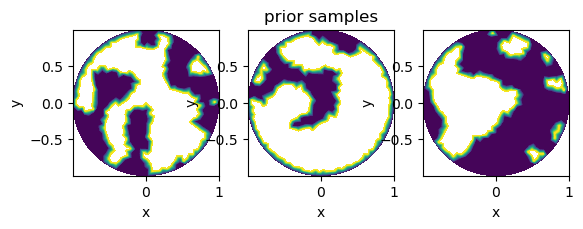

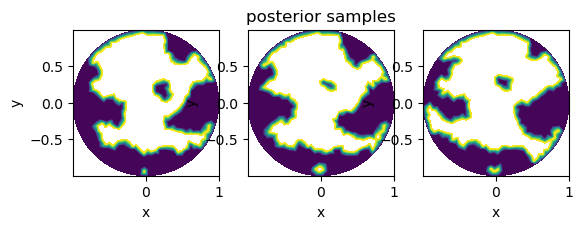

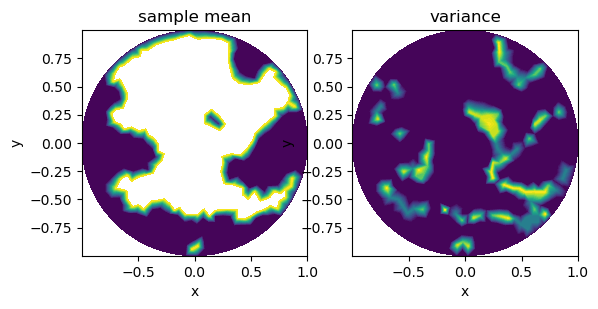

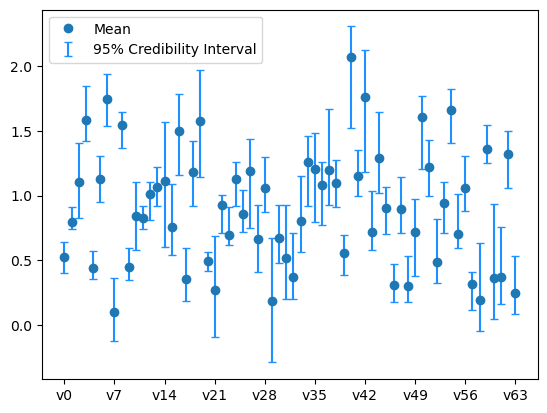

In [6]:
noise_percent = 5 # 5% noise
print("Running EIT for noise percent: ", noise_percent)
run_EIT(noise_percent, Ns=50, Nb=20, Nt=4) #TEMP: Ns=1000000, Nb=200000, Nt=4000 

Running EIT for noise percent:  10
Sample 50 / 50

Average acceptance rate: 0.24 MCMC scale: 0.1411383056531783 



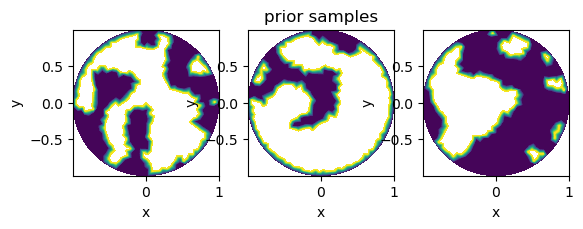

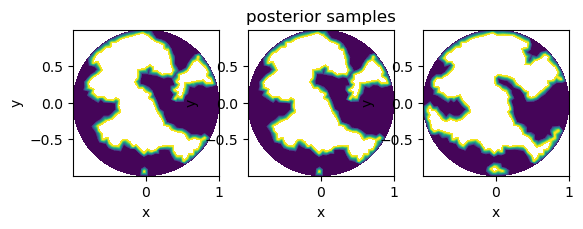

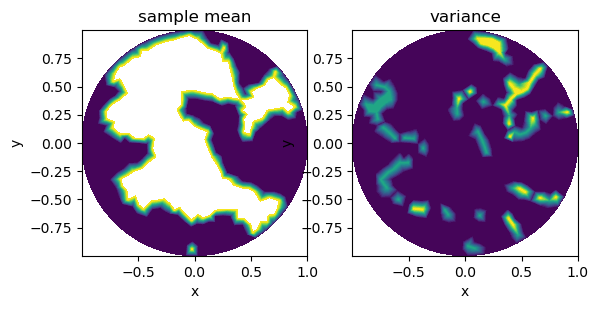

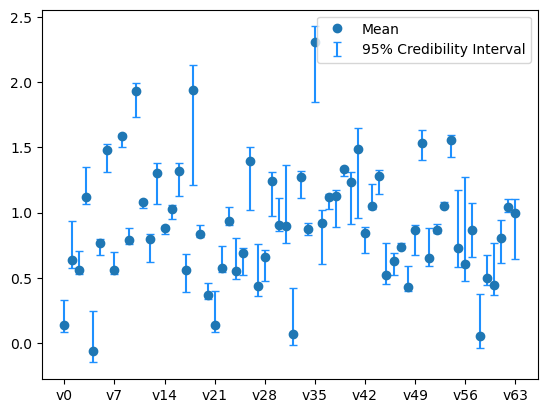

In [7]:
noise_percent = 10 # 10% noise
print("Running EIT for noise percent: ", noise_percent)
run_EIT(noise_percent, Ns=50, Nb=20, Nt=4) #TEMP: Ns=1000000, Nb=200000, Nt=4000 

Running EIT for noise percent:  20
Sample 50 / 50

Average acceptance rate: 0.24 MCMC scale: 0.1411383056531783 



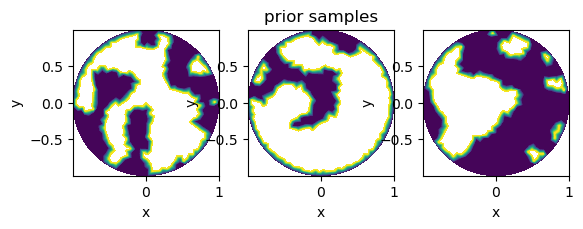

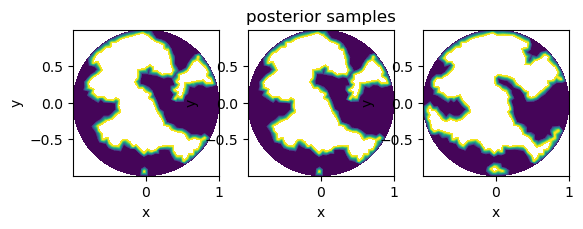

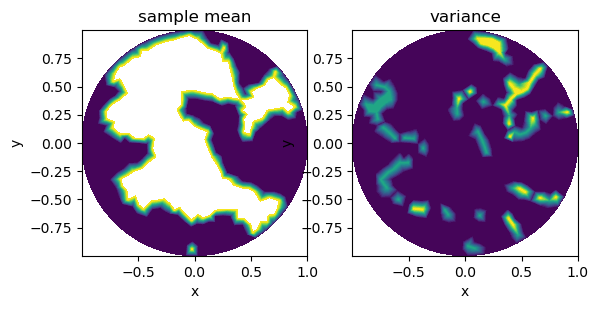

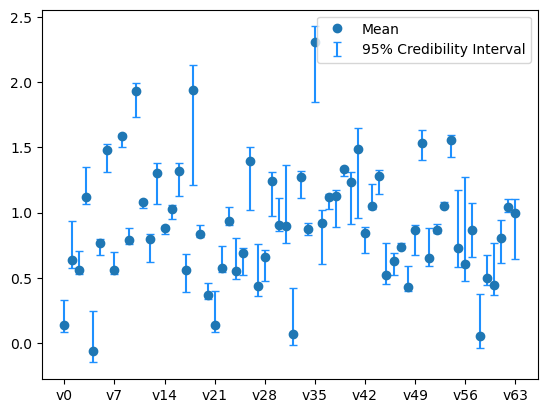

In [8]:
noise_percent = 20 # 20% noise
print("Running EIT for noise percent: ", noise_percent)
run_EIT(noise_percent, Ns=50, Nb=20, Nt=4)  #TEMP: Ns=1000000, Nb=200000, Nt=4000 

Then we run the following code cells to generate the exact paper figures from the samples generated above, these figures are saved in `plots` folder.

Set up `matplotlib` parameters:

In [9]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Load the data:

In [10]:
#%% Load the sample files
print('loading ...')
print('data 1 ...')
data1 = np.load('./stat/stat_circular_inclusion_2_5per_noise_thinned.npz')
samples1 = data1['samples']
print('data 2 ...')
data2 = np.load('./stat/stat_circular_inclusion_2_10per_noise_thinned.npz')
samples2 = data2['samples']
print('data 3 ...')
data3 = np.load('./stat/stat_circular_inclusion_2_20per_noise_thinned.npz')
samples3 = data3['samples']

#%% Load the exact conductivity and the data
obs_data3 = np.load('./data/obs_circular_inclusion_2_20per_noise.npz')
data = obs_data3['data']
exact_data = obs_data3['b_exact']

loading ...
data 1 ...
data 2 ...
data 3 ...


Create the domain geometry domain_geometry again (for plotting purposes):

In [11]:
# Load mesh
mesh = dl.Mesh("mesh.xml")

# Define function spaces 
parameter_space = dl.FunctionSpace(mesh, "CG", 1)
solution_space = dl.FunctionSpace(mesh, "CG", 1)

# extracting indices for elements at the boundary of the computational mesh
bnd_idx = extract_boundary_dofs_indices(solution_space)

# Create the domain geometry
G_Heavi = create_domain_geometry(parameter_space, bnd_idx)

Create Samples objects:

In [12]:
cuqi_samples1 = Samples(samples1, geometry=G_Heavi)
cuqi_samples2 = Samples(samples2, geometry=G_Heavi)
cuqi_samples3 = Samples(samples3, geometry=G_Heavi)

Create prior samples to be plotted:

In [13]:
x = Gaussian(0, 1, geometry=G_Heavi)
prior_samples = x.sample(5)

Create plot directory if it does not exists

In [14]:
if not os.path.exists('./plots'):
    os.makedirs('./plots')

Plot figure 6:

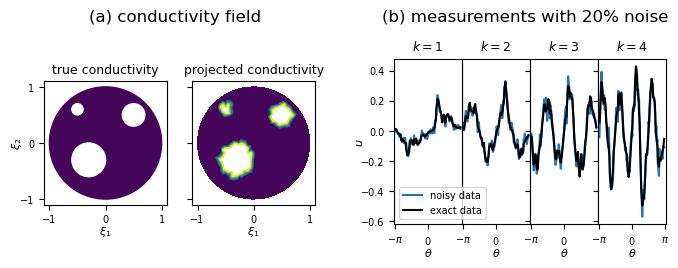

In [15]:
plot_figure6(parameter_space, exact_data, data)
plt.savefig('./plots/data.pdf',format='pdf')

Plot figure 7:

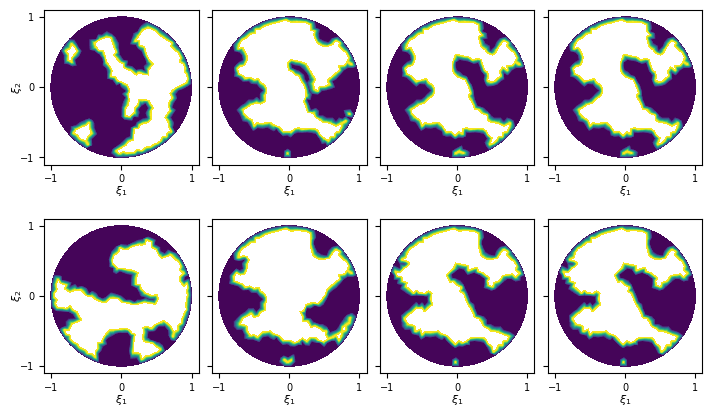

In [16]:
plot_figure7(prior_samples, cuqi_samples1, cuqi_samples2, cuqi_samples3,
             prior_samples_idx_to_plot=[0, 2], 
             posterior_samples_idx_to_plot=[0, 1]) # TEMP: samples_idx_to_plot=[2, -10] 
plt.savefig('./plots/samples.pdf',format='pdf')

Plot figure 8:

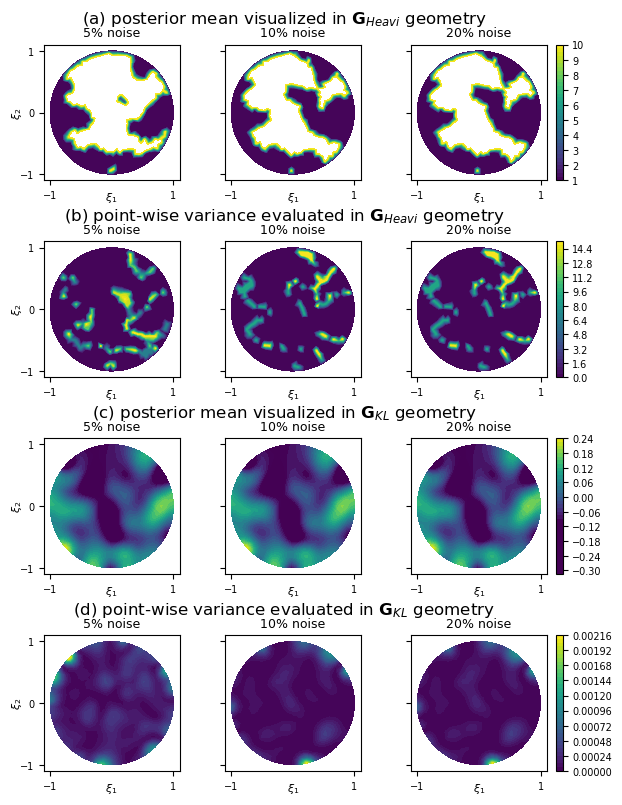

In [17]:
plot_figure8(cuqi_samples1, cuqi_samples2, cuqi_samples3)
plt.savefig('./plots/uq.pdf',format='pdf')

Plot figure 9:

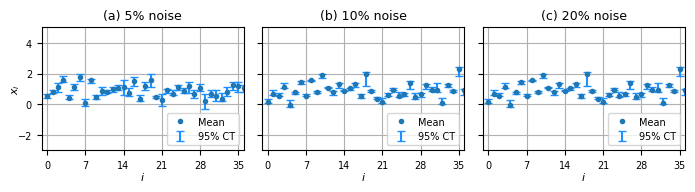

In [18]:
plot_figure9(cuqi_samples1, cuqi_samples2, cuqi_samples3)
plt.savefig('./plots/params.pdf',format='pdf')